<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab  


</br>  
</br>  
*Authors:*
 - Joseph Nelson (DC)      
 - Boom Devahastin Na Ayudhya  (NYC)   
 - Bethany Poulin (Boston) 



---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install statsmodels
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [227]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


In [228]:
# Change index to datetime:

data.index = pd.to_datetime(data.index)

In [229]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


In [230]:
data.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [231]:
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [232]:
# Not working: weekly_sales = pd.DataFrame(data['Weekly_Sales'].groupby(data['Store']==1).index).sum())
mask=data['Store']==1
data=data[mask]
weekly_sales = pd.DataFrame(data['Weekly_Sales'].groupby(data.index).sum())
weekly_sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

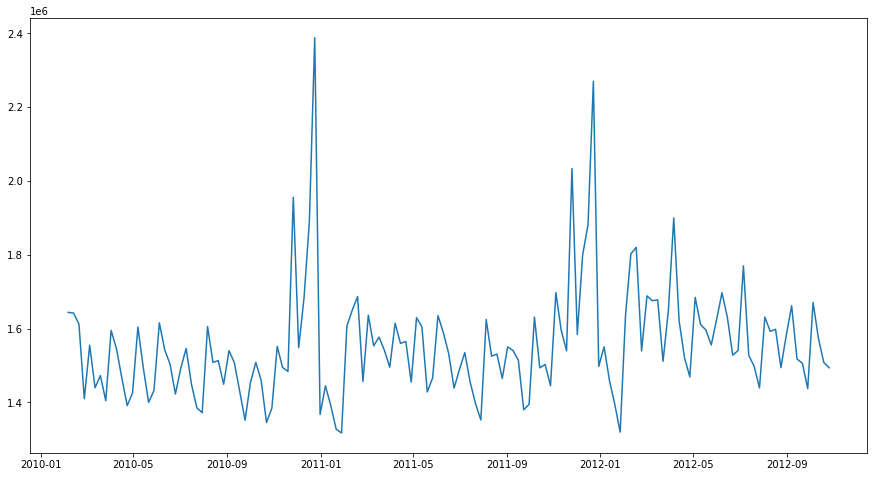

In [233]:
plt.figure(figsize=(15,8))
plt.plot(weekly_sales)

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

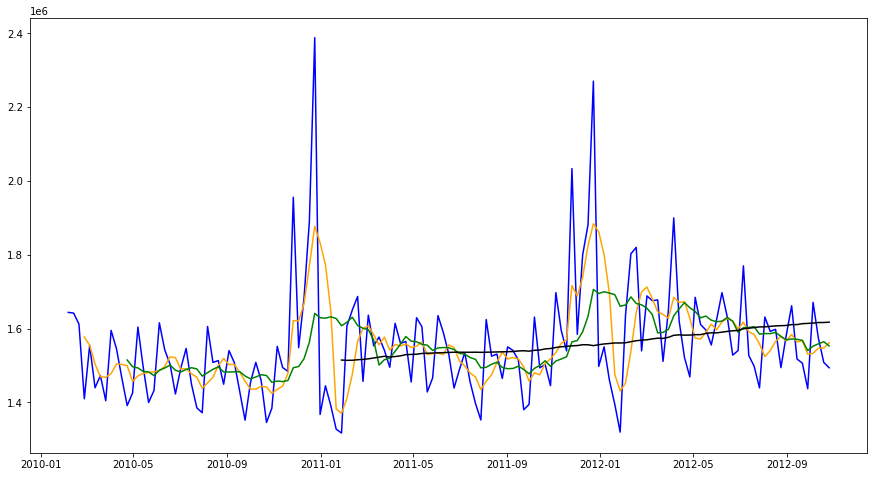

In [234]:
k1  = weekly_sales.rolling(window = 1).mean()
k4  = weekly_sales.rolling(window = 4).mean()
k12 = weekly_sales.rolling(window = 12).mean()
k52 = weekly_sales.rolling(window = 52).mean()

plt.figure(figsize=(15,8))
plt.plot(k1, color='blue')
plt.plot(k4, color='orange')
plt.plot(k12, color='green')
plt.plot(k52, color='black')

**2c. What can you say about trends in the data based on the rolling mean plot above?**

*Answer:*
There appears to be some seasonality to this data, particularly around the holidays. Otherwise, any patterns are difficult to discern.

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [235]:
# 1 week:

weekly_sales["Weekly_Sales"].autocorr(lag=1)

0.3021582794113126

In [236]:
# 2 weeks:

weekly_sales["Weekly_Sales"].autocorr(lag=2)

0.12741313055390097

In [237]:
# 52 weeks:

weekly_sales["Weekly_Sales"].autocorr(lag=52)

0.8953760294777008

**3b. What can you say about the series based on these autocorrelations?**

Answer:

There is a somewhat strong autocorrelation occuring from one week to the next, a weaker effect of sales from two weeks agon on the current week, and a rather strong effect of sales from a year ago on this week (seasonality).

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

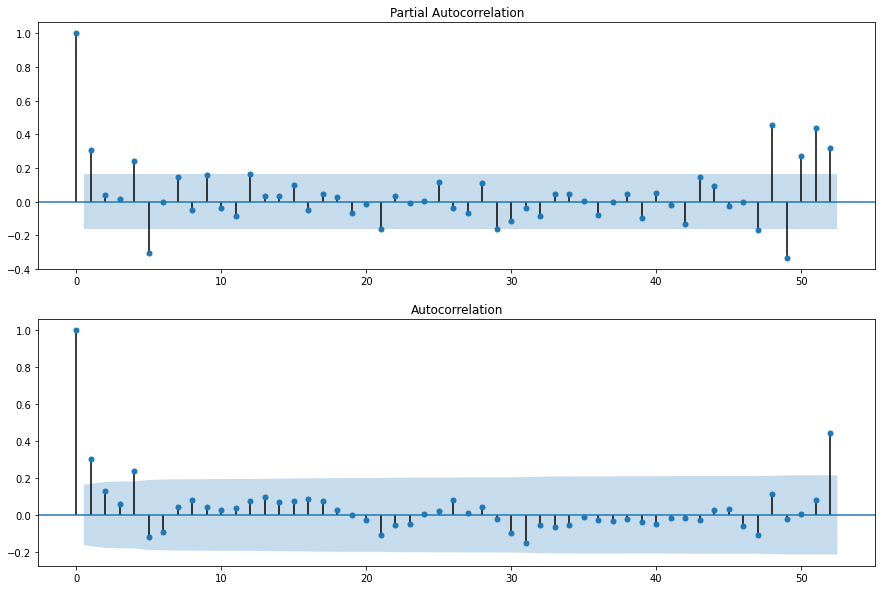

In [238]:
# Draw plot:

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(212)
fig = plot_acf(weekly_sales, lags=52, ax=ax1)

ax2 = fig.add_subplot(211)
fig = plot_pacf(weekly_sales, lags=52, ax=ax2);

# Code adapted from GA-DSI-Lecture-9.03-ARIMA-Modeling

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer: 

There is a temporal relationship between weekly sales and sales from lags 1,4, and 5 in both the ACF and PACF plots. The PACF plot demonstrates a positive temporal relationship at lags 48, 50, 51, and 52, and a negative relationshiop at lag 49. The positive temporal relationship at Week 52 (1-year) exists in both the ACF and PCF. 

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer:

p and q hyperparameter values can be informed by the temporal correlations demonstratd by both ACF and PACFat weeks 1, 4, 5, and 52. This is intuititve--we would expect similarity from week to week, month to month, and year to year.   

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [239]:
weekly_sales.shape

(143, 1)

In [240]:
143 * .75

107.25

In [241]:
143 - 107

36

In [242]:
train = weekly_sales.iloc[:108,]

test =weekly_sales.iloc[108:,]

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. (*Note that this is the same thing as an ARIMA(1,0,0) model.*)

**6a. Instantiate and fit an `AR(1)` model.**

In [243]:
# Split training into values and dates:
train_values = train['Weekly_Sales'].values
train_dates = train.index

# Fit:
ar1 = AR(train_values, train_dates).fit()

# Split test into values and dates:
test_values = test['Weekly_Sales'].values
test_dates  = test.index

# Start and end dates for pred:
start = test.index[0]
end = test.index[-1]

# Generate predictions on starting and ending dates.
ar1_pred = ar1.predict(start = start,
                       end = end)

# Code adapted from solutions

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [244]:
# Needed to make a data frame (thanks, solutions)--
# kept getting an error about mismatched matrix size.

date_list =  pd.date_range(start, periods=35, freq ='W')
preds = pd.DataFrame(ar1_pred, index=date_list, columns = ['Weekly Sales'])

error = mean_squared_error(test_values, preds)
error

9834237361.270716

**6c. How effective do you think this `AR(1)` model is?**

Answer: Looks OK, but could probably be improved.

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

In [245]:
# Calc resids:

residuals = test['Weekly_Sales'].values - preds['Weekly Sales'].values

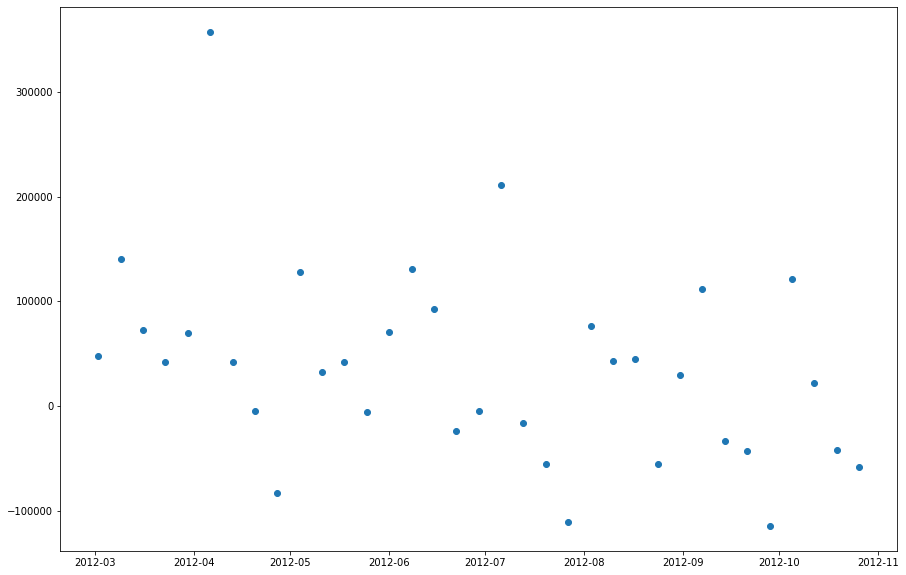

In [246]:
# Plot:

plt.figure(figsize=(15,10))
plt.scatter(test['Weekly_Sales'].index, residuals);

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer: The residuals are not distributed randomly around the zero y-axsis value, and there is at least one glaring outleir. This suggests the model's predictions are not consistently accurate. 

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [247]:
# Fit:

ar2 = ARIMA(endog = train_values,
            dates = train_dates,
            order = (2,0,0)).fit()

In [248]:
# Predict:

ar2_pred = ar2.predict(start = start, end = end)

In [249]:
# Train MSE:

mean_squared_error(train_values, ar2.predict())

25669024746.935253

In [250]:
# TEst MSE:

mean_squared_error(test_values, ar2_pred)

11333864527.319592

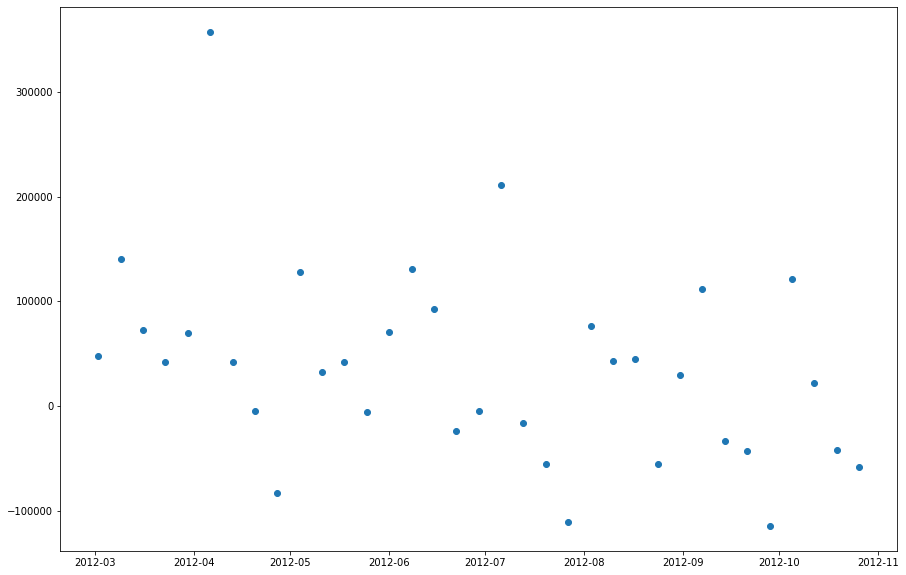

In [251]:
# Plot: 
ar2residuals = test['Weekly_Sales'].values - preds['Weekly Sales'].values

plt.figure(figsize=(15,10))
plt.scatter(test['Weekly_Sales'].index, ar2residuals);

**8b. How did your results change?**

Answer: This model appears to be performing slightly worse than ar1.

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [252]:
# Fit:

ar2_2 = ARIMA(endog = train_values,
            dates = train_dates,
            order = (2,0,2)).fit()

In [253]:
# Predict:

ar2_2_pred = ar2_2.predict(start = start, end = end)

In [254]:
# Train MSE:

mean_squared_error(train_values, ar2_2.predict())

21365568376.28775

In [255]:
#Test MSE

mean_squared_error(test_values, ar2_2_pred)

11347834995.556875

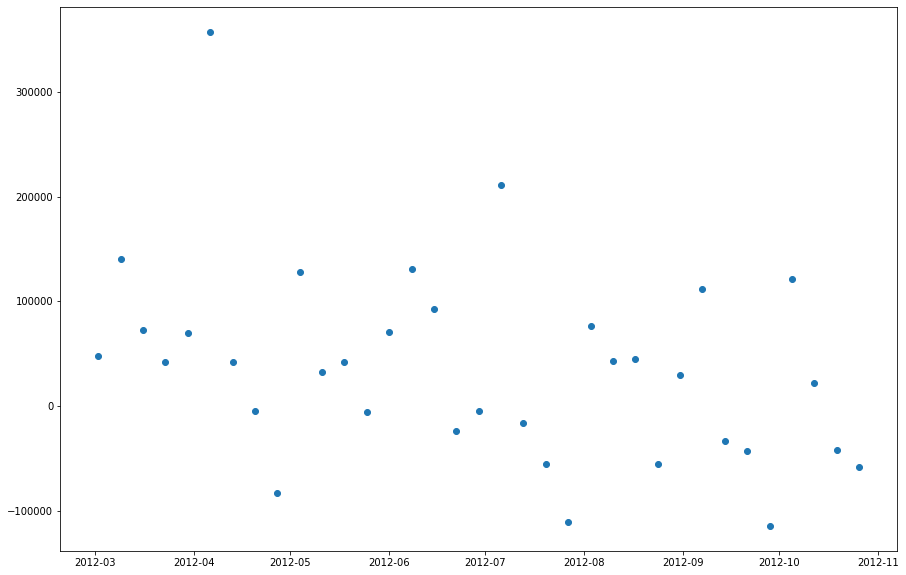

In [256]:
# Plot: 
ar2_2residuals = test['Weekly_Sales'].values - preds['Weekly Sales'].values

plt.figure(figsize=(15,10))
plt.scatter(test['Weekly_Sales'].index, ar2_2residuals);

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer: The model again apepars to be performong worse than in the above models.

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [257]:
# Dickey Fuller Test:

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Code Adapted from GA-DSI Lesson 9.03

In [258]:
# Interpret:

interpret_dftest(adfuller(data['Weekly_Sales'].dropna()))

Test Statistic   -3.761327
p-value           0.003329
dtype: float64

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer: The results appear to be statistically significant at the p < .05 level, meaning we can reject the null hyptohesis and our data are stationary.

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [259]:
# Create time period diffs for weekly sales:

weekly_sales['diff1'] = weekly_sales['Weekly_Sales'].diff()
weekly_sales.head()

,Weekly_Sales,diff1
Date,,
2010-02-05,1643690.90,NaN
2010-02-12,1641957.44,-1733.46
2010-02-19,1611968.17,-29989.27
2010-02-26,1409727.59,-202240.58
2010-03-05,1554806.68,145079.09


In [260]:
weekly_sales['diff2'] = weekly_sales['Weekly_Sales'].diff(2)
weekly_sales.head()

,Weekly_Sales,diff1,diff2
Date,,,
2010-02-05,1643690.90,NaN,NaN
2010-02-12,1641957.44,-1733.46,NaN
2010-02-19,1611968.17,-29989.27,-31722.73
2010-02-26,1409727.59,-202240.58,-232229.85
2010-03-05,1554806.68,145079.09,-57161.49


In [261]:
weekly_sales['diff3'] = weekly_sales['Weekly_Sales'].diff(3)
weekly_sales.head()

,Weekly_Sales,diff1,diff2,diff3
Date,,,,
2010-02-05,1643690.90,NaN,NaN,NaN
2010-02-12,1641957.44,-1733.46,NaN,NaN
2010-02-19,1611968.17,-29989.27,-31722.73,NaN
2010-02-26,1409727.59,-202240.58,-232229.85,-233963.31
2010-03-05,1554806.68,145079.09,-57161.49,-87150.76


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [262]:
# Using same function as defined above:

interpret_dftest(adfuller(weekly_sales['Weekly_Sales'].dropna()))

Test Statistic   -5.102186
p-value           0.000014
dtype: float64

In [263]:
interpret_dftest(adfuller(weekly_sales['diff1'].dropna()))

Test Statistic   -7.261575e+00
p-value           1.676180e-10
dtype: float64

In [264]:
interpret_dftest(adfuller(weekly_sales['diff2'].dropna()))

Test Statistic   -6.206249e+00
p-value           5.648528e-08
dtype: float64

In [265]:
interpret_dftest(adfuller(weekly_sales['diff3'].dropna()))

Test Statistic   -5.160622
p-value           0.000011
dtype: float64

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer: None, based on the above p-values.

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer: Uncertain. The data seem stationary, but testing will tell us.

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [266]:
# Instnatiate:

model = ARIMA(endog = train_values,
              dates = train_dates,
              order = (2, 1, 2))

In [267]:
# Fit ARIMA model:
arima = model.fit()

In [268]:
# Generate predictions based on test set:

arima_preds = model.predict(params= arima.params,
                      start = start, 
                      end = end)

In [269]:
# MSE:

mean_squared_error(test_values, arima_preds)

2530614317553.312

**11b. Interpret the results from the last answer.**


Answer: This model's performance appears better than the above efforts.

#### 12.  SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

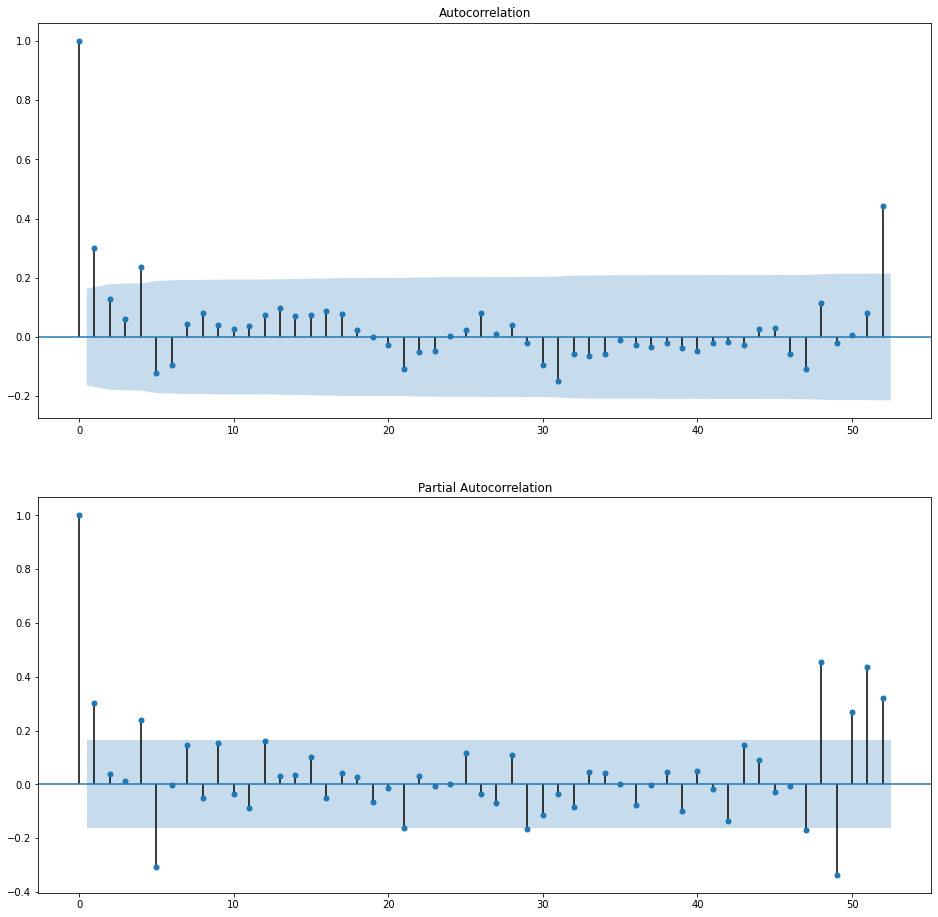

In [213]:
# Was struggling a bit with the SARIMAX model... aim to return to it at a later point.
# The below code is adopted from the 9.02 Solution

fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(211)
fig = plot_acf(weekly_sales.Weekly_Sales, lags=52, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(weekly_sales.Weekly_Sales, lags=52, ax=ax2)

plt.show();

In [224]:
# This is just a guess based on the solution code--need to return to this problem:

sarima = SARIMAX(endog = train['Weekly_Sales'].dropna(),
                 order = (2, 0, 2),
                 seasonal_order = (0, 1, 0, 53)).fit()

sarima_preds = sarima.predict(start=start, end = end)

In [225]:
mean_squared_error(test_values, sarima_preds)

14079944518.859428

**12b. How did your best SARIMAX model perform?**

Answer: The MSE suggests it performed better than the previous models, though I'll need to return to this at a later point to more clearly grasp how the optimal seasonal order was chosen.

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

In [270]:
sarima = SARIMAX(endog = train['Weekly_Sales'].dropna(),
                 order = (2, 0, 2),
                 seasonal_order = (0, 1, 0, 53)).fit()

sarima_pred = sarima.predict(start=start, end = end)

In [274]:
preds = pd.DataFrame(sarima_pred.values, index=date_list, columns = ['Weekly Sales'])

#train_test_plot(train, preds)

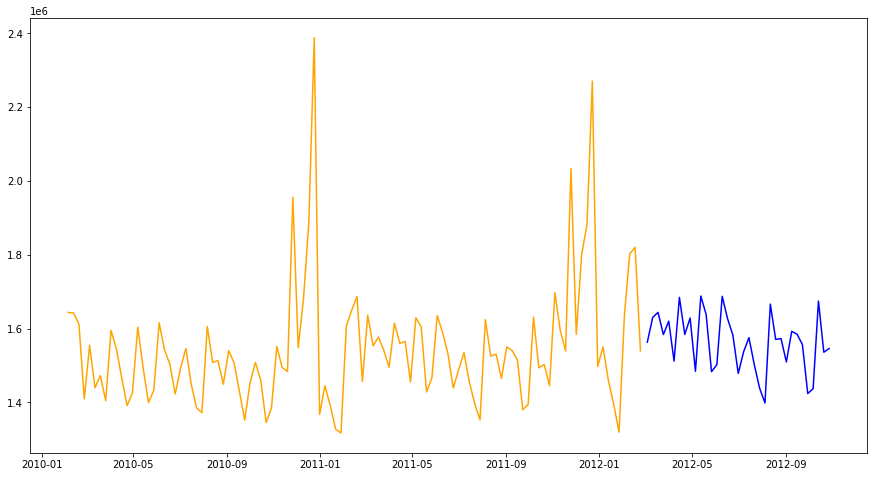

In [276]:
# Plot predictions and data from best-performing model:

plt.figure(figsize=(15,8))
plt.plot(preds, color='blue')
plt.plot(train, color='orange')

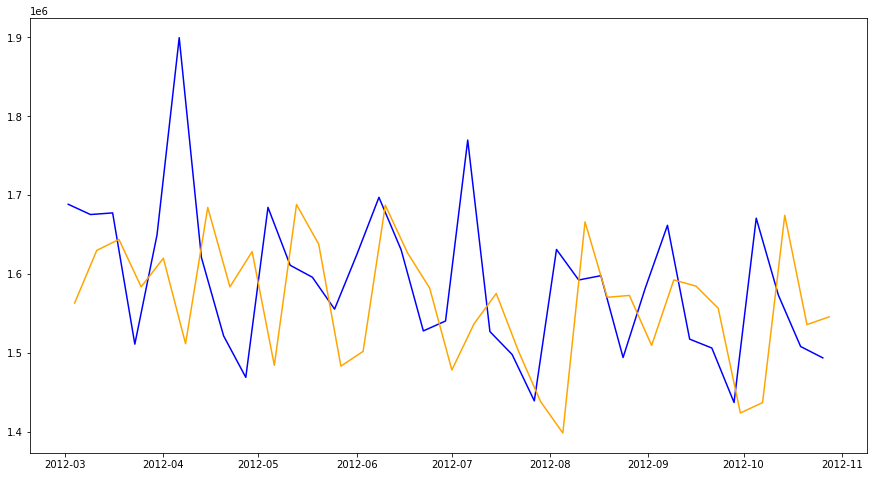

In [278]:
# Plot redisuals (test v preds) from best-performing model:

plt.figure(figsize=(15,8))
plt.plot(test, color='blue')
plt.plot(preds, color='orange')

**13b. How does our model perform at predicting weekly sales moving forward?** 

Answer: Since it does not simply revert to an average or straight line, I would say the SARIMAX performs quite well, even though, as mentioned above, I need to return to this topic to better understand the workings of SARIMAX. 

**13c. How might you improve it?**

Answer: Looking at other holidays outside of winter might be interesting, then including them as exogenous data. It also might helkp to have data from a wider time-range availalble. 

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: